 8919
Number of landkreise 405
Number of population 8239


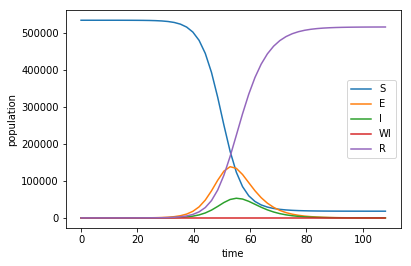

 [[9181, 1, 18, 54, 120071, 'DE21E'], [9188, 1, 83, 54, 136092, 'DE21L'], [9162, 1, 584, 53, 1471508, 'DE212'], [9179, 1, 46, 53, 219320, 'DE21C'], [9189, 2, 44, 51, 177089, 'DE21M'], [3401, 1, 6, 47, 77607, 'DE941'], [9184, 1, 220, 47, 348871, 'DE21H'], [9178, 1, 212, 39, 179116, 'DE21B'], [8117, 1, 110, 26, 257253, 'DE114'], [8416, 1, 114, 26, 227331, 'DE142'], [5370, 3, 808, 25, 254322, 'DEA29'], [8116, 1, 322, 25, 533859, 'DE113'], [8311, 1, 149, 25, 230241, 'DE131'], [8315, 1, 133, 25, 262795, 'DE132'], [8325, 1, 10, 25, 139455, 'DE135'], [5166, 1, 39, 24, 298935, 'DEA1E'], [8115, 1, 67, 24, 391640, 'DE112'], [8118, 1, 176, 24, 543984, 'DE115'], [9562, 1, 17, 24, 111962, 'DE252'], [1060, 1, 29, 23, 276032, 'DEF0D'], [5170, 1, 66, 23, 459809, 'DEA1F'], [5314, 1, 73, 23, 327258, 'DEA22'], [5334, 1, 178, 23, 555465, 'DEA2D'], [5962, 1, 31, 23, 412120, 'DEA58'], [6531, 1, 56, 23, 268876, 'DE721'], [7312, 1, 14, 23, 99845, 'DEB32'], [8125, 1, 139, 23, 343068, 'DE118'], [8226, 1, 232, 2

In [58]:
import csv
import json
import numpy as np
import urllib
from datetime import datetime, timedelta
import time
from scipy.integrate import odeint
import matplotlib.pyplot as plt



#SEIR model:
#as an input it needs:
#the timespan from today to the first infected case
#the number of people living in a community
#the number of people reported infected on the first day



#Output:number of infected todays
def modelprediction(timespan,N,rep):

#Parameters taken from:
#https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
#this could be an alternative source
#http://gabgoh.github.io/COVID/index.html?CFR=0.02&D_hospital_lag=5&D_incbation=5.2&D_infectious=2.9&D_recovery_mild=11.1&D_recovery_severe=28.6&I0=1&InterventionAmt=0.33333333333333337&InterventionTime=107.46666666666667&P_SEVERE=0.2&R0=2.2&Time_to_death=32&logN=15.761420707019587

    beta=1.75 #transmission probability
    tau=0.2  #incubation rate 
    #rho is one as we first do not make the distinction between
    #symptomatic and asymptomatic infections
    rho=1 #probability of symptomatically infected
    mu=0.5 #removal rate

    k=[beta, tau, rho, mu]
    #setting up our deterministic ODE model 
    # function that returns dy/dt
    # in our case y is a vector with the compartments S E I WI R
    #k is our vector with the parameters

    #Implementation  with symptomatic and asymptomatic
    #but probably for our case we do not need it, then set parameter rho==1
    def model(y,t,k):
        s=y[0]
        ep=y[1]
        i=y[2]
        wi=y[3]
        r=y[4]
        dsdt = -k[0]*s*i
        depdt = k[0]*s*i-k[1]*ep
        didt = k[1]*k[2]*ep-k[3]*i
        dwidt =k[1]*(1-k[2])*ep-k[3]*wi
        drdt =k[3]*wi+k[3]*i
        dydt = [dsdt, depdt, didt, dwidt, drdt]
        return dydt

    # initial condition
    #we classify the infected as exposed and calculate back in time
    y0=[1-rep/N,rep/N,0,0,0]

    #Here we will determine for how long we need to let the model run
    #Duration between today and first infection
    #we can just assume in average 8 days the first was an exposed
    #this assumption realys on a testing time from 1-3 days and 
    #an incubation time from 5-6 days
    timecorrection=8

    timespancorr=timespan+timecorrection

    #beginning of the time point
    t = np.linspace(0,timespancorr)
    
    # solve ODEs
    y=odeint(model,y0,t,args=(k,))

    #now we calculate the number of infected at the day today.
    numbinf=round((y[-1][2]+y[-1][3])*N) #we have to round the number of people, since there are no uneven people

    return numbinf,y,t;


# writes results of the simulation as a list to a csv 
def write_results(result_list,csv_out_file):

    with open(csv_out_file, 'w', newline='') as f:
        writer = csv.writer(f, delimiter = ' ')
        for elem in result_list:
            writer.writerow(elem)

# pulls the latest data from rki webpage, workaround to pull all entrys not only the first 80 
def pull_rki_data():
    import urllib.request, json 
    from datetime import timedelta, date

    def daterange(start_date, end_date):
        for n in range(int ((end_date - start_date).days)):
            yield start_date + timedelta(n)

    start_date = date(2020, 1, 1)
    end_date = date.today() + timedelta(days=1)
    
    #json_comp =json.dumps({})
    json_comp = []

    #crawls all data from January to March...this might take a while
    for single_date in daterange(start_date, end_date):
        with urllib.request.urlopen("https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0//query?where=Meldedatum%3D%27"+str(single_date.strftime("%Y-%m-%d"))+"%27&objectIds=&time=&resultType=none&outFields=*&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token=") as url:
            json_data = json.loads(url.read().decode("utf-8"))
            json_comp.append(json_data)# json_comp.append(json_data)
            
    #print("",json_comp)
    return(json_comp)


#loads the json file with the current infected people as well as a csv with population data and nuts3 
# estimates the first date of infection and the number of cases and saves all necessary data into a list
def load_data(csvfile):
    
    res = urllib.request.urlopen('https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json')
    res_body = res.read()

    data = []
    population_list = []
    landkreis_list= []
      
    with open(csvfile, 'r') as landkreis_file:
            reader = csv.reader(landkreis_file, delimiter=';')
            line = landkreis_file.readline()
            for line in reader:
                population_list.append(line[9:12])
                    


    #arcgis = json.loads(res_body.decode("utf-8"))
    arcgis =  pull_rki_data()
    #Go over all landkreise in arcgis data and extract all different names
    landkreise = []
    
    number = 0
       # print("Element: ",elem)
    for elem in arcgis:
        if 'features' in elem and elem['features']:
            #print("features")
            for feature in elem['features']:
                number = number +1
                if not any(x == feature['attributes']['IdLandkreis'] for x in landkreise):
                    if not feature['attributes']['IdLandkreis'] == '0-1':
                        landkreise.append(feature['attributes']['IdLandkreis'])

    print("",number)
                
    print("Number of landkreise",len(landkreise))
    print("Number of population",len(population_list))
    
    
     
    # for each landkreis estimate the earliest occurence data ---> then get all cases for this day     
    for landkreis in landkreise:

            occurrence_date = 0
            first_occurrence = 0
            first_alert_date = []
            number_of_cases_on_first_date = 0
            number_of_cases = 0
            pop = 0
            nuts3 = ''
            
            for elem in arcgis:
                if 'features' in elem and elem['features']:
                    for feature in elem['features']:
                        total_case_numbers = 0

                        if landkreis == feature['attributes']['IdLandkreis']: 
                            alert_date = feature['attributes']['Meldedatum'] 
                            diff_now_alert_date = 1584835200000 - alert_date #date of today at midnight serves as reference TODO change to date of today dynamically
                            diff_now_alert_date = diff_now_alert_date/(1000*60*60*24)
                                
                            occurrence_date = int(diff_now_alert_date)

                            if occurrence_date > first_occurrence:
                                first_occurrence = occurrence_date
                                first_alert_date =feature['attributes']['Meldedatum'] 

            for elem in arcgis:
                if 'features' in elem and elem['features']:
                    for feature in elem['features']:  
                        if landkreis == feature['attributes']['IdLandkreis']:
                            number_of_cases  = number_of_cases + feature['attributes']['AnzahlFall']
                            if first_alert_date == feature['attributes']['Meldedatum']:
                                number_of_cases_on_first_date = number_of_cases_on_first_date + feature['attributes']['AnzahlFall']


            for line in population_list:
                if not line[0] == '0-1':
                    if int(line[0]) == int(landkreis):
                        pop = int(line[1])
                        nuts3 = line[2]

            landkreis_list.append([int(landkreis),number_of_cases_on_first_date,number_of_cases,first_occurrence, pop, nuts3])
            
    return landkreis_list
          

if __name__== "__main__":

    csvfile = 'C:/Users/thomass/Desktop/RKI-COVID-mit-Einwohnerzahl_und_NUTS3_pro_Fall.csv'
    landkreis_list = load_data(csvfile)
    results_list =[]
    
    for elem in landkreis_list:
        # elem[0] landkreisID
        # elem[1] case on first date
        # elem[2] case now
        # elem[3] days
        # elem[4] population
        # elem[5] nuts3
        num_infected_model,y,t = modelprediction(elem[3],elem[4],elem[1])
        num_undocumented =  num_infected_model -elem[2]
        results_list.append([elem[2],num_infected_model,num_undocumented,elem[5],elem[4]])
    

    num_infected_model,sol,t = modelprediction(100,landkreis_list[11][4],landkreis_list[11][1]) #
    #this was plotting for a sanity check
    #plot results
    plt.plot(t,np.round(sol*landkreis_list[11][4])) #[:,1:]
    plt.legend(["S","E","I","WI","R"]) #
    plt.xlabel('time')
    plt.ylabel('population')
    #plt.yscale('log')
    plt.show()

    

    
    write_results(landkreis_list,'C:/Users/thomass/Desktop/RKI-COVID_out.csv')    
    write_results(results_list,'C:/Users/thomass/Desktop/RKI-COVID_results.csv')

    print("",landkreis_list)
    # list with: 
    # Landkreis ID
    # number_of_cases_on_first_date
    # number_of_cases_now
    # first_occurrence in days
    # population
    # nuts3




